In [1]:
import os
import fastai
import torch
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import timm
from google.colab import drive

set_seed(42)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/Colab/chest_xray'

In [4]:
print("GPU Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("cuDNN Available:", torch.backends.cudnn.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No GPU")

GPU Available: True
CUDA Version: 12.1
cuDNN Available: True
GPU Device Name: Tesla T4


In [5]:
def prepare_pneumonia_data(data_path):
    """
    Preparar dataset de imagenes de pulmones con o sin neumonía y generar dataloader

    Args:
        data_path (Path): Path del directorio de datos

    Returns:
        dls (dls): dataloader de fast.ai
    """
    # Define DataBlock for medical image classification
    pneumonia_blocks = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=[Resize(224, method='squish')],
        batch_tfms=[
            *aug_transforms(
                mult=1.0,  # Default augmentation scaling
                do_flip=True,
                flip_vert=False,
                max_rotate=10.0,
                min_zoom=0.8,
                max_zoom=1.2,
                max_lighting=0.2,
                max_warp=0.2,
                p_affine=0.75,
                p_lighting=0.75
            )
        ]
    )

    # Create DataLoaders
    dls = pneumonia_blocks.dataloaders(data_path, bs=32, device='cuda')

    return dls

In [6]:
def create_and_train_pneumonia_model(dls, model_arch='densenet121', pretrained=True, epochs=20):
    """
    Crear y entrenar modelo

    Args:
        dls (dls): dataloader de fast.ai
        model_arch (str): arquitectura del modelo (default: 'densenet121')
        pretrained (bool): usar modelo preentrenado (default: True)
        epochs (int): numero de epocas (default: 20)

    Returns:
        Learner: Learner de fast.ai entrenado
    """
    model = timm.create_model(
        model_arch,
        pretrained=pretrained,
        num_classes=dls.c
    )

    learn = Learner(
        dls,
        model,
        metrics=[error_rate, accuracy],
        loss_func=CrossEntropyLossFlat()
    )

    learn.fit_one_cycle(
        epochs,
        lr_max=1e-3,
        wd=0.05
    )

    return learn

In [7]:
dls = prepare_pneumonia_data(path)

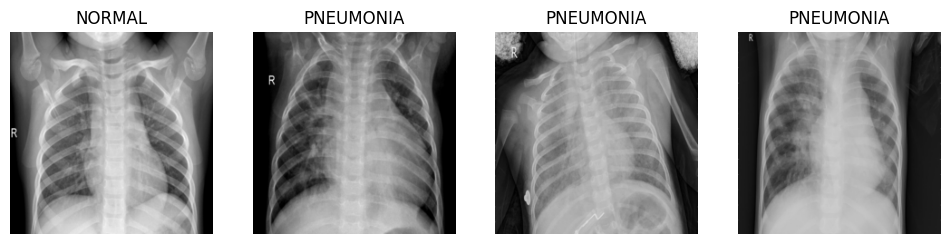

In [8]:
dls.valid.show_batch(max_n=4, nrows=1)

In [9]:
learn = create_and_train_pneumonia_model(dls)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.201928,0.120709,0.043553,0.956447,09:31
1,0.123052,0.131433,0.046114,0.953886,02:58
2,0.128142,0.131450,0.049530,0.950470,02:59
3,0.139363,0.288091,0.134927,0.865073,02:59
4,0.117829,0.457601,0.181896,0.818104,02:58
5,0.116699,0.183079,0.055508,0.944492,02:56
6,0.106329,0.146117,0.042699,0.957301,02:57
7,0.104734,0.081155,0.033305,0.966695,02:56
8,0.115577,0.097205,0.032451,0.967549,02:56
9,0.097511,0.089426,0.029889,0.970111,02:56


In [10]:
def evaluate_model(learn):
    """
    Evaluar modelo y generar interpretacion

    Args:
        learn (Learner): fast.ai Learner entrenado

    Returns:
        Diccionario con resultados de evaluacion
    """
    # Confusion Matrix
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    plt.title('Confusion Matrix for Pneumonia Detection')
    plt.show()

    # Top losses
    interp.plot_top_losses(4)
    plt.show()

    # Metricas detalladas
    cm = interp.confusion_matrix()
    print("\nConfusion Matrix:")
    print(cm)

    # Calcular precision, recall, y F1 score
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'confusion_matrix': cm
    }

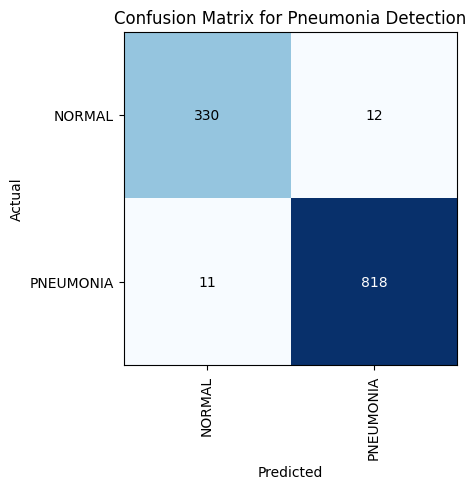

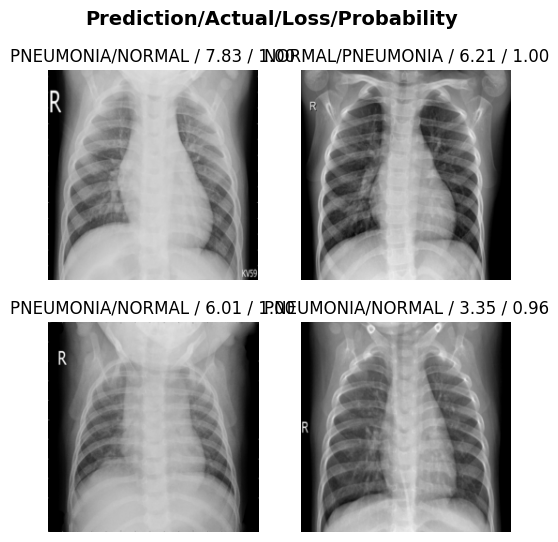


Confusion Matrix:
[[330  12]
 [ 11 818]]

Model Evaluation Results:
precision: 0.9855421686746988
recall: 0.9867310012062727
f1_score: 0.9861362266425557
confusion_matrix: [[330  12]
 [ 11 818]]


In [11]:
eval_results = evaluate_model(learn)
print("\nModel Evaluation Results:")
for metric, value in eval_results.items():
    print(f"{metric}: {value}")

In [12]:
# Exportar modelo
learn.export('pneumonia_detector.pkl')